In [3]:
# First, an example blocky inversion with pygimli
import numpy as np
import matplotlib.pyplot as plt

import pygimli as pg
from pygimli.viewer.mpl import drawModel1D

In [4]:
#simulate
nlay = 2  # number of layers
lam = 200.  # (initial) regularization parameter
errPerc = 3.  # relative error of 3 percent
ab2 = np.logspace(-1, 2, 50)  # AB/2 distance (current electrodes)
mn2 = ab2 / 3.  # MN/2 distance (potential electrodes)

In [5]:
f = pg.core.DC1dModelling(nlay, ab2, mn2)

In [6]:
synres = [100., 500.]  # synthetic resistivity
synthk = [2]  # synthetic thickness (nlay-th layer is infinite)

In [7]:
rhoa = f(synthk+synres)
rhoa = rhoa * (pg.randn(len(rhoa), seed=0) * errPerc / 100. + 1.)

In [8]:
transThk = pg.trans.TransLog()  # log-transform ensures thk>0
transRho = pg.trans.TransLogLU(1, 1000)  # lower and upper bound
transRhoa = pg.trans.TransLog()  # log transformation for data

In [9]:
f.region(0).setTransModel(transThk)  # 0=thickness
f.region(1).setTransModel(transRho)  # 1=resistivity

In [10]:
paraDepth = max(ab2) / 3.  # rule-of-thumb for Wenner/Schlumberger
f.region(0).setStartValue(paraDepth / nlay / 2)
f.region(1).setStartValue(np.median(rhoa))

/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 


In [11]:
inv = pg.core.Inversion(rhoa, f, transRhoa, True)  # data vector, fop, verbose
# could also be set by inv.setTransData(transRhoa)

In [12]:
inv.setRelativeError(errPerc / 100.0)  # alternative: setAbsoluteError in Ohmm
inv.setLambda(lam)  # (initial) regularization parameter
inv.setMarquardtScheme(0.9)  # decrease lambda by factor 0.9
model = f.createStartVector()  # creates from region start value
model[nlay] *= 1.5  # change default model by changing 2nd layer resistivity
inv.setModel(model)  #

min/max(dweight) = 33.3333/33.3333


/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


In [13]:
import time
start = time.time()
model = inv.run()  # result is a pg.Vector, but compatible to numpy array
res, thk = model[nlay-1:nlay*2-1], model[0:nlay-1]
print('rrms={:.2f}%, chi^2={:.3f}'.format(inv.relrms(), inv.chi2()))
print(f"TIME {time.time() - start}")

rrms=3.21%, chi^2=1.135use model trans from RegionManager
min/max(dweight) = 33.3333/33.3333
Building constraints matrix
constraint matrix of size(nBounds x nModel) 3 x 3
check Jacobian: wrong dimensions: (0x0) should be (50x3)  force: 1
jacobian size invalid, forced recalc: 1
calculating jacobian matrix (forced=1)...... 0.013 s
min data = 97.0846 max data = 485.28 (50)
min error = 0.03 max error = 0.03 (50)
min response = 134.331 max response = 195.758 (50)
calc without reference model
0: rms/rrms(data, response) = 137.914/40.4884%
0: chi^2(data, response, error, log) = 320.358
0: Phi = 16017.9 + 9.9047 * 200 = 16017.9
Iter: 0
use local regularization
solve CGLSCDWWtrans with lambda = 200
1: LS newModel: min = 1.21316; max = 454.862
1: LS newResponse: min = 121.139; max = 451.548
1: rms/rrms(data, LS newResponse) = 45.5692/27.3942%
1: chi^2(data, LS newResponse, error, log) = 60.4557
1: Phi = 3022.79+4.03128*200=3022.79
Linesearch tau = 0.83
1: Model: min = 1.68342; max = 405.03
1: Re

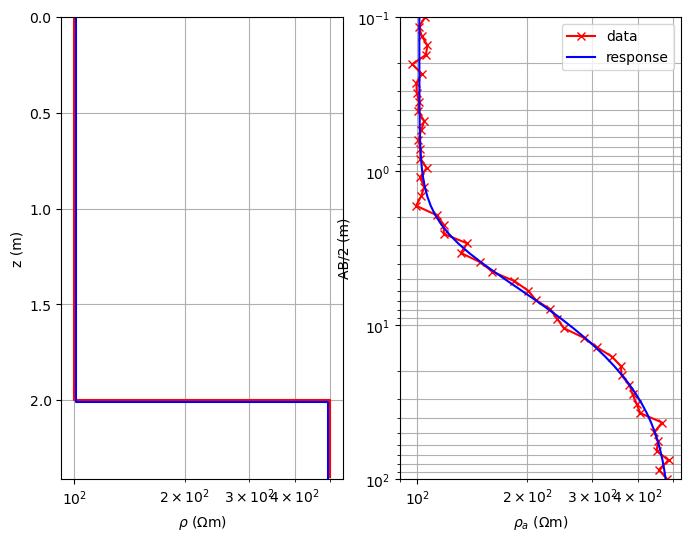

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))  # two-column figure
drawModel1D(ax[0], synthk, synres, plot='semilogx', color='r')
drawModel1D(ax[0], thk, res, color='b')
ax[0].grid(True, which='both')
ax[0].set_ylabel('z (m)')
ax[0].set_xlabel(r'$\rho$ ($\Omega$m)')
ax[1].loglog(np.array(rhoa).reshape(len(rhoa),1), np.array(ab2).reshape(len(ab2),1), 'rx-', label='data')  # sounding curve
ax[1].loglog(np.array(inv.response()), np.array(ab2).reshape(len(ab2),1), 'b-', label='response')
ax[1].set_ylim((max(ab2), min(ab2)))  # downwards according to penetration
ax[1].grid(True, which='both')
ax[1].set_xlabel(r'$\rho_a$ ($\Omega$m)')
ax[1].set_ylabel('AB/2 (m)')
ax[1].legend(loc='best')
plt.show()

In [15]:
# first try at a residuals function
nlay = 3  # number of layers
lam = 200.  # (initial) regularization parameter
errPerc = 3.  # relative error of 3 percent
ab2 = np.logspace(-1, 2, 50)  # AB/2 distance (current electrodes)
mn2 = ab2 / 3.  # MN/2 distance (potential electrodes)
f = pg.core.DC1dModelling(nlay, ab2, mn2)
    
transThk = pg.trans.TransLog()  # log-transform ensures thk>0
transRho = pg.trans.TransLogLU(1, 1000)  # lower and upper bound
transRhoa = pg.trans.TransLog()  # log transformation for data
    
f.region(0).setTransModel(transThk)  # 0=thickness
f.region(1).setTransModel(transRho)  # 1=resistivity
    
synres = [100., 500., 200]  # synthetic resistivity
synthk = [2, 5]  # synthetic thickness (nlay-th layer is infinite)
    
def residuals(x):      
    return f(x) - f(synthk+synres)

In [22]:
from scipy.optimize import least_squares
start2 = time.time()
x0 = [10, 5, 200, 200, 200]
res_1 = least_squares(residuals, x0, method='lm')
print(time.time() - start2)

1.318439245223999


In [23]:
res_1.x # Nice!

array([  2.,   5., 100., 500., 200.])

In [37]:
# okay, testing this for different starting parameters. 
d1 = np.linspace(0.01, 10, 5)
d2 = np.linspace(0.01, 10, 5)
p1 = np.linspace(1, 1000, 5)
p2 = 266
p3 = 266

d11, d12, p11 = np.meshgrid(d1, d2, p1)


def optimize_2_layer(depth1, depth2, p1, right_model=[2, 5, 100, 500, 200]):
    x0 = [depth1, depth2, p1, 266, 266]
    res_1 = least_squares(residuals, x0, method='lm')
    print(f"CASE: {x0}, NORM RESIDUALS: {(np.array(right_model) - res_1.x)/np.array(x0)}")
    return np.sqrt(np.sum(((np.array(right_model) - res_1.x)/np.array(right_model))**2)) #normalized residuals

voptimize_2_layer = np.vectorize(optimize_2_layer, otypes=[np.ndarray])

In [38]:
reses = voptimize_2_layer(d11, d12, p11)

CASE: [0.01, 0.01, 1.0, 266, 266], NORM RESIDUALS: [ 1.83787993e+02  5.10418899e+02  7.41351851e+01  8.80715855e-01
 -1.37765298e-01]
CASE: [0.01, 0.01, 250.75, 266, 266], NORM RESIDUALS: [ 1.99999791e+02  4.16101180e+02 -6.99304635e-01  1.44374995e+00
  9.05213321e-02]
CASE: [0.01, 0.01, 500.5, 266, 266], NORM RESIDUALS: [ 1.99998870e+02  4.99000004e+02 -8.00199800e-01  8.79699262e-01
 -2.48119067e-01]
CASE: [0.01, 0.01, 750.25, 266, 266], NORM RESIDUALS: [ 1.99998373e+02  4.99000016e+02 -8.66711096e-01  8.79699270e-01
 -2.48118222e-01]
CASE: [0.01, 0.01, 1000.0, 266, 266], NORM RESIDUALS: [ 1.99995663e+02  4.99994028e+02 -9.19533629e-01  5.02375605e+00
  1.00580532e-01]
CASE: [2.5075, 0.01, 1.0, 266, 266], NORM RESIDUALS: [-1.06262622e-15  2.48689958e-12  0.00000000e+00 -6.62460896e-15
  2.13697063e-16]
CASE: [2.5075, 0.01, 250.75, 266, 266], NORM RESIDUALS: [-5.31313112e-16  8.88178420e-14 -5.66733987e-17 -1.70957651e-15
  1.06848532e-16]
CASE: [2.5075, 0.01, 500.5, 266, 266], NORM 

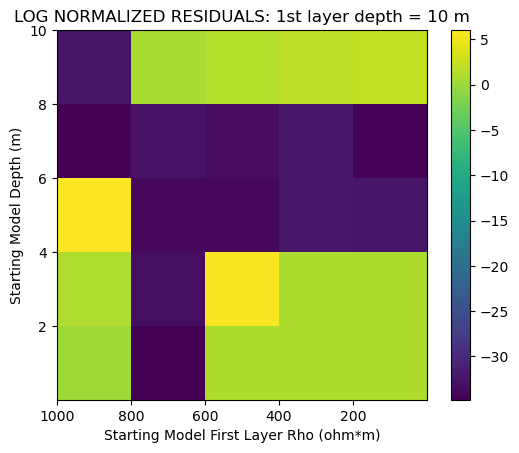

In [70]:
plt.imshow(np.log(reses[4].astype(float)), extent=[max(p1),min(p1),min(d1),max(d1)], aspect=max(p1)/max(d1))
plt.title("LOG NORMALIZED RESIDUALS: 1st layer depth = 10 m")
plt.ylabel("Starting Model Depth (m)")
plt.xlabel("Starting Model First Layer Rho (ohm*m)")
plt.colorbar()

array([[[   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ]],

       [[   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ]],

       [[   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ]],

       [[   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
        [   1.  ,  250.75,  500.5 ,  750.25, 1000.  ],
    

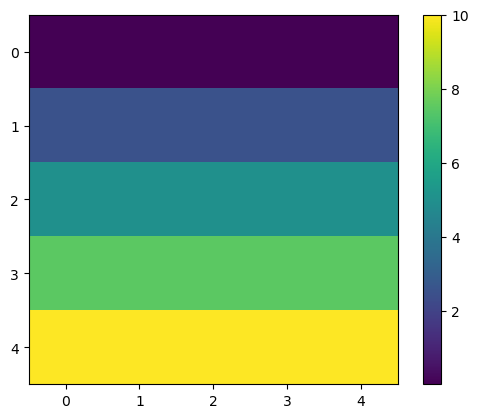

In [53]:
plt.imshow(d11[0])
plt.colorbar()
p11

In [15]:
def invert(depth, p1, p2, right_model=[2, 100, 500]):
    inv = pg.core.Inversion(rhoa, f, transRhoa, True)  # data vector, fop, verbose
    inv.setRelativeError(errPerc / 100.0)  # alternative: setAbsoluteError in Ohmm
    inv.setLambda(lam)  # (initial) regularization parameter
    inv.setMarquardtScheme(0.9)  # decrease lambda by factor 0.9
    # model = f.createStartVector()  # creates from region start value
    # model[nlay] *= 1.5  # change default model by changing 2nd layer resistivity   
    model = [depth, p1, p2]
    print(f"MODEL: {model}")
    inv.setModel(model)  #
    model = inv.run()
    return np.sqrt(np.sum(((np.array(right_model) - np.array(model))/np.array(right_model))**2)) #normalized residuals

vinvert = np.vectorize(invert, otypes=[np.ndarray])

In [ ]:
reses2 = vinvert(d11, p11, p21)

MODEL: [0.01, 1.0, 1.0]min/max(dweight) = 33.3333/33.3333

use model trans from RegionManager
min/max(dweight) = 33.3333/33.3333
Building constraints matrix
constraint matrix of size(nBounds x nModel) 3 x 3
calculating jacobian matrix (forced=1)...... 0.013 s
min data = 97.0846 max data = 485.28 (50)
min error = 0.03 max error = 0.03 (50)
min response = 1 max response = 1 (50)
calc without reference model
0: rms/rrms(data, response) = 256.221/99.3464%
0: chi^2(data, response, error, log) = 30335.6
0: Phi = 1.51678e+06 + 1304.17 * 200 = 1.51678e+06
Iter: 0
use local regularization
solve CGLSCDWWtrans with lambda = 200
Linesearch tau = 1
1: Model: min = 0.01; max = 1
1: Response: min = 1; max = 1
1: rms/rrms(data, Response) = 256.221/99.3464%
1: chi^2(data, Response, error, log) = 30335.6
1: Phi = 1.51678e+06+1304.16*200=1.51678e+06
Iter: 1
calculating jacobian matrix (forced=1)...... 0.013 s
use local regularization
solve CGLSCDWWtrans with lambda = 180
Linesearch tau = 1
2: Model: min 